# Data Fundamentals (H)
John H. Williamson -- Session 2019/2020

----

Read the submission instructions **carefully** before submitting. Note that marks shown are **provisional** and could change after grading.

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**



---

## Lab 2: **Assessed**
# Numerical arrays and vectorized computation


### Notes
It is recommended to keep the lecture notes open while doing this lab exercise.

**This exercise is assessed**. Make sure you upload your solution by the deadline. See the notes at the bottom of this notebook for submission guidance.


### References
If you are stuck, the following resources are very helpful:


* [NumPy cheatsheet](https://github.com/juliangaal/python-cheat-sheet/blob/master/NumPy/NumPy.md)
* [NumPy API reference](https://docs.scipy.org/doc/numpy-1.13.0/reference/)
* [NumPy user guide](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.html)


* [Python for Data Science cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PythonForDataScience.pdf)
* [Another NumPy Cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)


## Purpose of this lab
This lab should help you:
* understand floating point representations
* understand how roundoff errors occur and how you can control them
* work with higher rank tensors, selecting the attributes you want to work with
* understand how to do simple operations in a vectorised manner

Note: this lab requires solving puzzles which require that you understand the course material. Very little code is required to get the correct solutions.


In [1]:
## custom utils
## uncomment and run the line below if you get an error about jhwutils
## then RESTART THE KERNEL (Kernel/Restart)

#!pip --no-cache install --user -U https://github.com/johnhw/jhwutils/zipball/master   

# comment it again before submitting!

  Created wheel for jhwutils: filename=jhwutils-1.0-cp37-none-any.whl size=31770 sha256=7b1796c576c604f22c444691fc48d0c4a6df236a319855c73cb7c421c40e71c6
  Stored in directory: C:\Users\Inesh\AppData\Local\Temp\pip-ephem-wheel-cache-x_yqc6ad\wheels\13\e0\14\4110265aeea8a2f4eb68ae88dc5477a4223fbd6b2470128b0e
Successfully built jhwutils


In [1]:
# Standard imports
# Make sure you run this cell!
# NumPy
import numpy as np  
np.set_printoptions(suppress=True)

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

from jhwutils.checkarr import array_hash, check_hash
from jhwutils.float_inspector import print_float_html
import jhwutils.image_audio as ia
import jhwutils.tick as tick

import lzma, base64
exec(lzma.decompress(base64.b64decode(b'/Td6WFoAAATm1rRGAgAhARYAAAB0L+Wj4AHWARFdAAUaCmNWCuiTCXe8bHWT/WeqghymfBRQKyklXJ3lgDWHk34myezvldkgSu3Adiur0vA+OkDfUwiMWzEclOxunCssCtgpVM94TwtylLQC9aX0APwnuNk2VBPkVpf3otXT04I1pElMWNdSgqgJ9/PqMJhdhfDr3Wrs/a/pRN/AOd+rZawioudIbGRTYZgWPHcqPLImmS2EO0Hbkc7kRAS3Nr9JkELrRMkejvVMnGgu+b1m4uXv6trDURkPrMO7HCVcO5FcMx1FURc+hNcKRmmBp1mCuW4iop6qRAMNnAur/spBmfuw+lbJkxOoIXMwrRuEXa6bnJz53WQnloXvzbWW5hqEtbPpSHPLPccxaiU5yPAKYAAAAADqkqJjsFbfFwABrQLXAwAA9LrSpbHEZ/sCAAAAAARZWg==')))

print("Everything imported OK")

Everything imported OK


C:\Users\Inesh\Anaconda3\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# 1. Financial misconduct

You have been asked to verify the computation of some financial predictive models. These models produces a sequence of updates to the value of a product. The product updates are mainly of two types:
* **large deposits**, representing inflows of new cash, often up into the billions of pounds
* **small returns** from high-frequency trading activity

The simulator produces **two** model outputs from two distinct models `a` and `b` at each time step, which provide very similar estimates of the value of these updates.

You are asked to write code that will produce:

* an estimate of the total value of a product over some series
* the total difference between two different product models, both of which are very similar.

You are given the existing code below, which is supposed to compute and return:

* the sum of the `a` updates (i.e. total value of `a`)
* the accumulated difference between the `a` and `b` products.

However, the result is very inaccurate when tested. Modify this code to be more accurate. Do NOT use NumPy, or *any* other external module to improve your calculation. Use floating point, regardless of the fact that floating point is not appropriate for financial data.

The errors should be less than 0.5 for the `a` sum and less than 1e-10 for the difference in predictions.

In [2]:
class Simulator: # we use a class just to hold variables between calls
    def __init__(self):
        # initialise accumulators
        self.a_sum = 0
        self.b_sum = 0
        
    def update(self, a, b):
        # increment
        self.a_sum += a
        self.b_sum += b
        
    def results(self):
        # return a  pair of results
        # (you do not need to change this)
        return self.a_sum, self.a_sum - self.b_sum
        

In [3]:
a_error, d_error = simulate(Simulator())
# bad result!
print(f"Error in a_sum is {a_error} and {d_error} in d_sum")

Error in a_sum is 13.7734375 and 4.101232676410264e-08 in d_sum


Copy and paste the `Simulator` into the cell below and modify it:

In [2]:
class Simulator:
    def __init__(self):
        self.a_sum = []
        self.b_sum = []

    def update(self, a, b):
        self.a_sum.append(a)
        self.b_sum.append(b)

    def _kahan(self, sum_list):
        s = 0
        c = 0
        for i in sum_list:
            y = i - c
            t = s + y
            c = (t - s) - y
            s = t
        return s

    def _subtract(self, a, b):
        return self._kahan([i-j for i,j in zip(a,b)])
        
    def results(self):
        return self._kahan(self.a_sum), self._subtract(self.a_sum, self.b_sum)

In [3]:
    
a_error, d_error = simulate(Simulator())
print(f"Error in a_sum is {a_error} and {d_error} in d_sum")

Error in a_sum is 0.0 and 0.0 in d_sum


In [120]:
with tick.marks(2):
    assert(a_error<2.0)

In [121]:
with tick.marks(2):
    assert(a_error<0.5)

In [122]:
with tick.marks(2):
    assert(d_error<1e-10)

In [123]:
with tick.marks(2):
    assert(d_error<1e-12)

# 2. Debugging the dump [1 hour]

Scenario: In your first day in a new post in the IT team in a finance company, you are provided with the a portion of a memory dump of a process that was running an important simulation of foreign exchange rates in the late 1990s. Unfortunately, the system crashed half way through and the raw memory dump is all that is left. You need to extract the relevant data so that the simulation can be restarted. 

You know the data is stored as a numerical array, so it has some known structure. You don't know the dtype or shape of the array, or where it starts or ends in the memory dump, however.

**This is a puzzle which will require careful thinking, but very little code to be written**

In [114]:
# read the data in
with open("data/crash_bytes.dump", "rb")  as f:
    crash_dump = f.read()

In [115]:
# the raw memory dump, in hex. This isn't too useful...
def print_hex(x):
    print(" ".join(["%02X" % byte for byte in x]))    
    
print_hex(crash_dump)

15 9B 75 2E 08 F9 51 9E 09 D5 DB D6 1E 5C D0 83 EF A9 3C 00 C0 F9 44 00 00 C0 7F B7 D2 DF 3F BD 66 12 3F A6 C5 F9 44 00 00 C0 7F B5 EB EA 3F 40 7C 0B 3F 4B CB F9 44 00 00 C0 7F 84 12 EE 3F 8B A3 09 3F F1 D0 F9 44 00 00 C0 7F 03 6E DA 3F 26 04 16 3F 97 D6 F9 44 00 00 C0 7F A3 5A D7 3F A3 28 18 3F 3C DC F9 44 00 00 C0 7F 82 E3 D2 3F 6B 61 1B 3F E2 E1 F9 44 00 00 C0 7F 8E D1 CC 3F 49 FC 1F 3F 88 E7 F9 44 00 00 C0 7F 3C 3E CF 3F 24 1D 1E 3F 2D ED F9 44 00 00 C0 7F 1B 98 CB 3F 99 F2 20 3F D3 F2 F9 44 00 00 C0 7F 7B 3D D1 3F D0 9A 1C 3F 78 F8 F9 44 00 00 C0 7F A8 A4 C5 3F 31 CB 25 3F 1E FE F9 44 00 00 C0 7F 87 11 BD 3F 19 50 2D 3F C4 03 FA 44 00 00 C0 7F 66 7C C6 3F FC 16 25 3F 69 09 FA 44 00 00 C0 7F 48 0C BD 3F E8 54 2D 3F 0F 0F FA 44 00 00 C0 7F 9A 6F BF 3F 66 2B 2B 3F B5 14 FA 44 00 00 C0 7F 61 12 C7 3F 9B 9A 24 3F 5A 1A FA 44 00 00 C0 7F D6 13 C9 3F 49 F6 22 3F 00 20 FA 44 00 00 C0 7F 2E EF C3 3F 5F 3D 27 3F 78 BC 63 AE 9A D9 33 3D C3 AE B5 69 CA 94 0A 00 41 B0 32 89 76 19 C4 1D 76 61 1

### What you know
All you have is the block of raw data you can see above.  You know the array is in there, but not exactly where it starts or stops.  The header information is gone, so there is no striding information/dope vector to go by.

* You know that the second column of the array consists soley of NaN

         a        b      c    ...
         ...     NaN 
         ...     NaN
         ...     NaN
         ...     NaN
              
* You also know that all *other* values are finite 
* All non-NaN values in the array are known to be positive.
* You can assume the data is some form of IEEE 754, though you do not know what specific type.
* The data starts on a byte boundary.

**This is sufficient information to solve the whole puzzle**

### Task
Recover the data, formatted correctly, and store it in the variable `recovered_array`. 

* This will take some trial and error (although there *is* a relatively fast way to do it).
      

* You can convert the data to a NumPy array like this:
`np.frombuffer(bytes, dtype, count, offset)`
* `bytes` the data to decode, as raw bytes
* `dtype` the datatype of the data to decode
* `count` the number of **elements** in the array
* `offset` **in bytes** to start recovering data
    

In [116]:
# A wrong example:
# try and read 18 words from offset 0
# reshape to a 6,3 array
# this clearly isn't right, as you will see
np.frombuffer(crash_dump, dtype=np.float64, count=18, offset=0).reshape(6,3)

array([[-1.24841114e-162, -2.62303079e-290,  2.33361140e-307],
       [-1.13240294e-013,  2.33362099e-307,  3.19176591e+001],
       [ 2.33363057e-307, -1.70122669e-254,  2.33364016e-307],
       [ 1.88224189e-124,  2.33364975e-307, -6.68454427e-139],
       [ 2.33365933e-307,  4.08685129e+208,  2.33366892e-307],
       [ 7.09165316e+044,  2.33367851e-307,  4.37642387e-134]])

* A hint: you can show how any NumPy memory will appear in memory in hex using `tobytes()` -- see the example below. Also, remember you need to infer the *shape* of the array.

In [117]:
# create a simple array, and then get the raw bytes and print them
print_hex(np.array([[1.0, 2.0, 3.0], 
                    [4.0, 0.0, 0.0]], dtype=np.float64).tobytes())

00 00 00 00 00 00 F0 3F 00 00 00 00 00 00 00 40 00 00 00 00 00 00 08 40 00 00 00 00 00 00 10 40 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00


In [395]:
# YOUR CODE HERE
recovered_array = np.frombuffer(crash_dump, dtype=np.float32, count=72, offset=19).reshape(18,4)

In [396]:
# test the shape
with tick.marks(5):        
    assert(check_hash(recovered_array.shape, ((2,), 77.0)))

In [397]:
# test if the result is correct   
with tick.marks(8):        
    assert(np.allclose(array_hash(recovered_array)[1], 1265119.8746899366, atol=1e-2, rtol=1e-2))

# 3. Working with tensors [1 hour]
The file `data/font_sheet.png` contains a number of characters in different fonts. It is an image which consists of the images of each *printable* ASCII character, (characters 32-128) arranged left to right. Each character image is precisely square. 

These are the characters present, in order:

In [6]:
chars = "".join([chr(i) for i in range(32,128)])
print(chars)

 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~


  
Each font is also stacked left to right, so the image is one *very* long strip of characters. The image is grayscale.

In [7]:
all_fonts = ia.load_image_gray("data/font_sheet.png")
print(all_fonts.shape)

(1856, 6144)


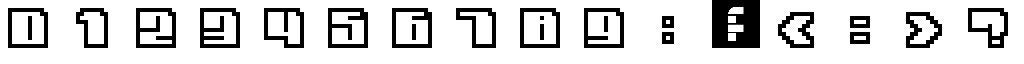

In [8]:
# show a portion of the image
ia.show_image(all_fonts[64:128, 1024:2048])

# Tasks
A. Rearrange the image into a tensor called `font_sheet` that is ordered like this:

        (font, character, rows, cols)
        
* Showing the image `font_sheet[16, 33, :, :]` should show the "A" character of the 17th font.
* Showing the image `font_sheet[10, 1, :, :]` should be the "!" character of the 11th font.

In [9]:
## hint
from jhwutils.matrices import show_boxed_tensor_latex
n = np.arange(36).reshape(2*3, 3*2)
show_boxed_tensor_latex(n, box_rows=False)
show_boxed_tensor_latex(n.reshape(2,3,2,3), box_rows=False)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
# YOUR CODE HERE
font_sheet = np.einsum("ijkl->ikjl", all_fonts.reshape(29,64,96,64))

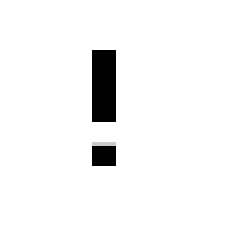

In [11]:
# if your code worked, you should see an ! below
ia.show_image_mpl(font_sheet[10, 1, :, :])

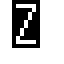

In [12]:
# if your code worked, you should see a gif of letters below
ia.show_gif(font_sheet[8, 33:33+26, :, :], width="20%")


In [13]:
# test shape is correct
with tick.marks(6):        
    assert(check_hash(font_sheet.shape, ((4,), 944.9499472573252)))


In [14]:
# test content is ok
with tick.marks(10):    
    assert(np.allclose(array_hash(font_sheet)[1], 55441039333148.88, atol=1e-2, rtol=1e-2))    

B. Create an array `letter_sample`, which will be a 2D image containing one letter from each of the letters in the lowercase alphabet, with each character in a different font. The results should show "a" in font 0, "b" in font 1, "c" in font 2 and so on, as a single continuous strip.

The letters should be arranged horizontally and contiguously in a strip in the output image:

       abcdefghijklmnopqrstuvwxyz


Hint:
* you will have to partially *undo* some of the swapping/reshaping you did earlier to get the data in the right format
* you need to use fancy indexing
* you'll need to slice -- work out how to slice the array correctly
* do not use a loop

In [144]:
# YOUR CODE HERE
letter_sample = np.einsum("ijk->jik",font_sheet[range(26), range(65, 91)]).reshape(64,1664)

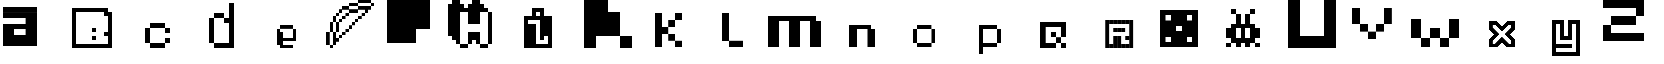

In [108]:
# each character should appear in a different font
ia.show_image(letter_sample)

In [109]:

with tick.marks(8):
    assert(check_hash(letter_sample,((64, 1664), 4815084617.957046)))

C. Compute the average representation of the letter "x" by taking the 64x64 mean image of the letter `x` across all fonts and store it in `average_x`.

        

In [110]:
# YOUR CODE HERE
average_x = np.mean(font_sheet[:, 88, :, :], axis=0)

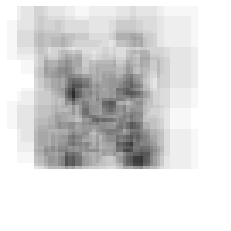

In [111]:
# show the result -- should be a 64x64 image
ia.show_image_mpl(average_x)

In [112]:
with tick.marks(5):    
    assert(check_hash(average_x, ((64, 64), 7278599.401423973)))

# End of assessed portion

----------------------------------

## Extended material

<font color="red"> Material beyond this point is optional. You do not have to attempt it or look at it. There are no marks. 
</font>

## Rendering fonts
Complete the function below. It should render text using the provided font index, and *return* a single array with the text rendered in a horizontal strip. It should use `font_sheet` that you defined earlier. You can assume equal spacing of letters. 

* You can compute the index of the character in the same units as the font sheet using the formula:

      ix = ord(char) - 32
    
Every ASCII character (32-127) should be rendered. Any character that could not be rendered should be rendered as a **blank white** square.    

* It is fine to use a `for` loop to solve this problem

In [ ]:
def render_text(string, font_index):
    """Returns an image with the given string rendered, using the font_index selected.
    Reads characters from font_sheet.
    string: String to be rendered.
    font_index: index of the font to use"""
    ix = [ord(char) - 32 if char in [chr(i) for i in range(32,128)] else 0 for char in string]
    return np.einsum("ijk->jik",font_sheet[font_index, ix, :, :]).reshape(64, len(ix)*64)

In [ ]:
# you should be able to read this
ia.show_image(render_text("Can you see this clearly?", 23))

In [ ]:
# this should look the same
ia.show_image(render_text("Can\tyou\nsee\xf5this\x00clearly?", 23))

In [ ]:
ia.show_image(render_text("Data Fundamentals (H)", 1))

In [ ]:
with tick.marks(0):
    assert(check_hash(render_text("Test 1", 1), ((64, 384), 269160963.20571893)))

In [ ]:
with tick.marks(0):
    assert(check_hash(render_text("Test 2", 2),((64, 384), 282670129.18082076)))

In [ ]:
with tick.marks(0):
    assert(check_hash(render_text("Test\n3", 3), ((64, 384), 283057779.18977338)))

In [ ]:
with tick.marks(0):
    assert(check_hash(render_text("\n\tTest\x00\xff4", 4), ((64, 576), 657469474.43368447)))

-----

# Submission instructions

## Mark summary
You should check the marks you've got before submitting. To do this, 
* Make sure you fill in any place that says `YOUR CODE HERE` or `"YOUR ANSWER HERE"`.
* SAVE THE NOTEBOOK, 
* Go to `Cell/Restart and Run All` in the menu.
* Check the output of the cell here.

Note that this is an estimated mark, and if you don't do the above procedure *carefully* you may get nonsense estimates.


In [ ]:
tick.summarise_marks()

<div class="alert alert-block alert-danger">
    
### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `week_<xxx>.ipynb`.

</div>


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Any form of plagiarism will be subject to the Plagiarism Policy. The penalties are severe.